In [1]:
#lets start with some imports

import importlib

#Py-ART, simply the best sowftware around.. Give those guys a grant
import cartopy
import pyart
#timezone info
import pytz

#plotting
from matplotlib import pyplot as plt

#plotting on a maop


import xarray as xr
import netCDF4


from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np
from cmac import cmac, quicklooks, get_sounding_times, get_sounding_file_name, config, cmac_processing
import copy


%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/Users/scollis/anaconda3/envs/cmac2/lib/python3.6/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/Users/scollis/anaconda3/envs/cmac2/lib/python3.6/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [2]:
verbose = True
sweep = 1

In [3]:
soundings_directory = '/data/CACTI/sonde/'
radar_directory = '/data/CACTI/csapr2/'


In [4]:
radar = pyart.io.read(radar_directory + 'corcsapr2cfrppiM1.a1.20181105.190003.nc')

In [5]:
radar.fields['differential_phase']['data'] = radar.fields['differential_phase']['data']*-1.0

In [6]:
ncf_sounding = netCDF4.Dataset(soundings_directory + 'corsondewnpnM1.b1.20181105.180000.cdf')

In [7]:
radar.fixed_angle

{'long_name': 'Ray target fixed angle',
 'units': 'degree',
 '_FillValue': -9999.0,
 'data': masked_array(data=[ 0.49987793,  1.4996338 ,  2.5982666 ,  3.8012695 ,
                     5.0976562 ,  6.498413  ,  7.998047  ,  9.602051  ,
                    11.299438  , 13.200073  , 15.501709  , 18.4021    ,
                    22.098999  , 26.900024  , 32.700806  ],
              mask=False,
        fill_value=1e+20,
             dtype=float32)}

In [8]:
rlat = radar.latitude['data'][0]
rlon = radar.longitude['data'][0]


#Get the date at the start of collection
index_at_start = radar.sweep_start_ray_index['data'][sweep]
time_at_start_of_radar = pyart.io.cfradial.netCDF4.num2date(radar.time['data'][index_at_start], 
                                  radar.time['units'])

#make a nice time stamp
pacific = pytz.timezone('US/Central')
local_time = pacific.fromutc(time_at_start_of_radar)
fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
print(fancy_date_string)

Monday November 05 at 01:00 PM CST


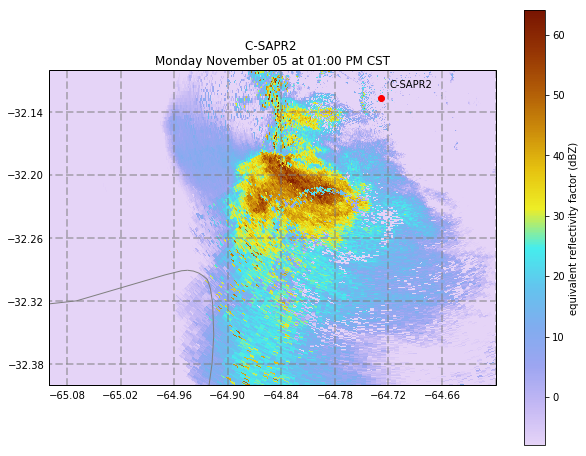

In [9]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'reflectivity', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-8, vmax=64, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

In [10]:
#This is a cludge to get the clutter field from the file
new_grid = radar.fields['reflectivity']['data'] - radar.fields['uncorrected_reflectivity_h']['data']
clutter = np.zeros(new_grid.shape, dtype=np.int)
possible_contamination = new_grid < -20.0
clutter[possible_contamination] = 1

z = radar.gate_altitude['data']
clutter[(z - z.min()) > 2000. ] = 0


In [11]:
clutter_field = {'data' : clutter,
                'standard_name' : 'clutter_mask',
                'long_name' : 'Clutter mask',
                'comment' : '0 is good, 1 is clutter',
                'valid_min' : 0,
                'valid_max' : 1,
                'units' : 'unitless'}
radar.add_field('clutter', clutter_field, replace_existing=True)

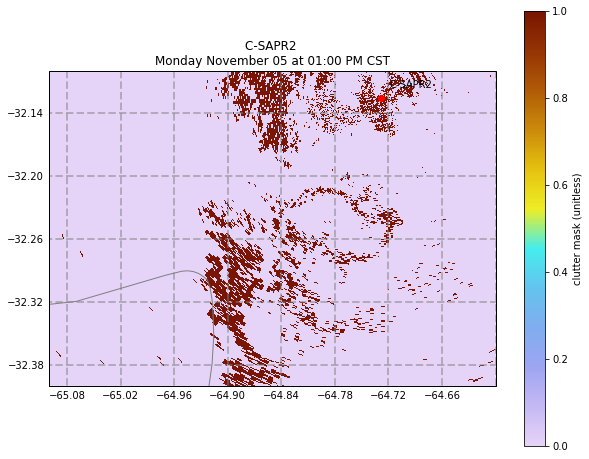

In [12]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'clutter', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=1, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

In [13]:
meta_config = config.get_metadata('cacti_csapr2_ppi')
cmac_config = config.get_cmac_values('cacti_csapr2_ppi')
field_config = config.get_field_names('cacti_csapr2_ppi')
field_config['reflectivity'] = 'uncorrected_reflectivity_h'

cmac_config['c_coef'] = 0.3
cmac_config['attenuation_a_coef'] = 0.08
cmac_config['d_coef'] = 1.0804
cmac_config['beta_coef'] = 0.64884

field_config['differential_reflectivity'] = 'differential_reflectivity'
cmac_config['zdr_offset'] = 0.0

In [14]:
radar.fields.keys()


dict_keys(['attenuation_corrected_differential_reflectivity', 'attenuation_corrected_differential_reflectivity_lag_1', 'attenuation_corrected_reflectivity_h', 'censor_mask', 'classification_mask', 'copol_correlation_coeff', 'differential_phase', 'differential_reflectivity', 'differential_reflectivity_lag_1', 'mean_doppler_velocity', 'mean_doppler_velocity_v', 'normalized_coherent_power', 'normalized_coherent_power_v', 'reflectivity', 'reflectivity_v', 'signal_to_noise_ratio_copolar_h', 'signal_to_noise_ratio_copolar_v', 'specific_differential_phase', 'spectral_width', 'spectral_width_v', 'uncorrected_copol_correlation_coeff', 'uncorrected_differential_phase', 'uncorrected_differential_reflectivity', 'uncorrected_differential_reflectivity_lag_1', 'uncorrected_mean_doppler_velocity_h', 'uncorrected_mean_doppler_velocity_v', 'uncorrected_reflectivity_h', 'uncorrected_reflectivity_v', 'uncorrected_spectral_width_h', 'uncorrected_spectral_width_v', 'unthresholded_power_copolar_h', 'unthresh

In [15]:
radar_start_date = netCDF4.num2date(radar.time['data'][0], radar.time['units'])
print('##', str(radar_start_date))

## 2018-11-05 19:00:03


In [16]:
temp_field = field_config['temperature']
alt_field = field_config['altitude']
vel_field = field_config['velocity']

In [17]:
z_dict, temp_dict = pyart.retrieve.map_profile_to_gates(ncf_sounding.variables[temp_field][:], 
                                                        ncf_sounding.variables[alt_field][:], 
                                                        radar)

texture =  cmac_processing.get_texture(radar, vel_field)
snr = pyart.retrieve.calculate_snr_from_reflectivity(radar)

In [18]:
radar.add_field('sounding_temperature', temp_dict, replace_existing=True)
radar.add_field('height', z_dict, replace_existing=True)
radar.add_field('signal_to_noise_ratio', snr, replace_existing=True)
radar.add_field('velocity_texture', texture, replace_existing=True)


In [19]:
rhv_field = field_config['cross_correlation_ratio']
ncp_field = field_config['normalized_coherent_power']
my_fuzz, _ = cmac_processing.do_my_fuzz(radar, rhv_field, ncp_field, tex_start=2.4,
                        tex_end=2.7, verbose=True)

radar.add_field('gate_id', my_fuzz,
                replace_existing=True)

##
## CMAC calculation using fuzzy logic:
##    Doing multi_trip
##    Doing rain
##    Doing snow
##    Doing no_scatter
##    Doing melting
##    Doing hard constraining melting
##     (array([   0,    0,    0, ..., 5404, 5404, 5404]), array([ 0,  1,  2, ..., 30, 31, 32]))
##    Doing hard constraining multi_trip
##     (array([1441, 1441, 1441, ..., 5404, 5404, 5404]), array([1023, 1024, 1025, ..., 1097, 1098, 1099]))
##    Doing hard constraining melting
##     (array([ 381,  382,  382, ..., 5404, 5404, 5404]), array([1099, 1093, 1094, ..., 1097, 1098, 1099]))
##    Doing hard constraining rain
##     (array([ 721,  721,  721, ..., 5404, 5404, 5404]), array([881, 882, 883, ..., 433, 434, 435]))
##    Doing hard constraining melting
##     (array([   0,    0,    0, ..., 5404, 5404, 5404]), array([   0,    1,    2, ..., 1097, 1098, 1099]))
2


In [20]:
radar.fields['gate_id']['data'][clutter == 1] = 5

In [21]:
notes = radar.fields['gate_id']['notes']
radar.fields['gate_id']['notes'] = notes + ',5:clutter'

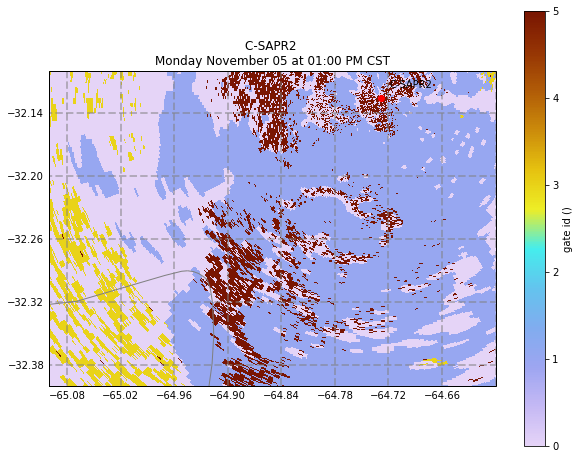

In [22]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'gate_id', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=5, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

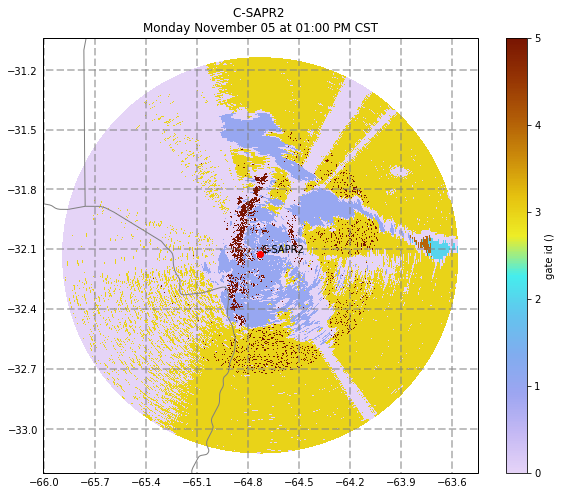

In [23]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'gate_id', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=5)

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

In [24]:
print(radar.fields['gate_id']['notes'])

0:multi_trip,1:rain,2:snow,3:no_scatter,4:melting,5:clutter


In [25]:
cat_dict = {}
for pair_str in radar.fields['gate_id']['notes'].split(','):
    cat_dict.update(
        {pair_str.split(':')[1]:int(pair_str.split(':')[0])})


In [26]:
cmac_gates = pyart.correct.GateFilter(radar)
cmac_gates.exclude_all()
cmac_gates.include_equal('gate_id', cat_dict['rain'])
cmac_gates.include_equal('gate_id', cat_dict['melting'])
cmac_gates.include_equal('gate_id', cat_dict['snow'])


In [27]:
radar.gate_altitude['data']

masked_array(
  data=[[ 1141.,  1141.,  1142., ...,  2333.,  2334.,  2336.],
        [ 1141.,  1141.,  1142., ...,  2354.,  2355.,  2357.],
        [ 1141.,  1141.,  1142., ...,  2375.,  2376.,  2378.],
        ...,
        [ 1141.,  1194.,  1249., ..., 60931., 60985., 61041.],
        [ 1141.,  1194.,  1249., ..., 60931., 60985., 61041.],
        [ 1141.,  1194.,  1249., ..., 60931., 60985., 61041.]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [28]:
#Bug: need to fix
radar.gate_altitude['data'] = radar.gate_altitude['data'].data

# Create a simulated velocity field from the sonde object.
u_field = field_config['u_wind']
v_field = field_config['v_wind']
u_wind = ncf_sounding.variables[u_field][:]
v_wind = ncf_sounding.variables[v_field][:]
alt_field = field_config['altitude']
sonde_alt = ncf_sounding.variables[alt_field][:]
profile = pyart.core.HorizontalWindProfile.from_u_and_v(
    sonde_alt, u_wind, v_wind)
sim_vel = pyart.util.simulated_vel_from_profile(radar, profile)
radar.add_field('simulated_velocity', sim_vel, replace_existing=True)


In [29]:
corr_vel = pyart.correct.dealias_region_based(
    radar, vel_field=vel_field, ref_vel_field='simulated_velocity',
    keep_original=False, gatefilter=cmac_gates, centered=True)

radar.add_field('corrected_velocity', corr_vel, replace_existing=True)

print('##    corrected_velocity')
print('##    simulated_velocity')

fzl = cmac_processing.get_melt(radar)


/Users/scollis/anaconda3/envs/cmac2/lib/python3.6/site-packages/pyart/correct/region_dealias.py:243: UserWarning: Warning: converting a masked element to nan.
  sref_means[reg-1] = np.ma.mean(sref[labels_corr == reg])


##    corrected_velocity
##    simulated_velocity
3966.0


In [30]:

ref_offset = cmac_config['ref_offset']
self_const = cmac_config['self_const']
# Calculating differential phase fields.
phidp, kdp = pyart.correct.phase_proc_lp_gf(
    radar, gatefilter=cmac_gates, offset=ref_offset, debug=True,
    nowrap=50, fzl=fzl, self_const=self_const)
phidp_filt, kdp_filt = cmac_processing.fix_phase_fields(
    copy.deepcopy(kdp), copy.deepcopy(phidp), radar.range['data'],
    cmac_gates)

radar.add_field('corrected_differential_phase', phidp,
                replace_existing=True)
radar.add_field('filtered_corrected_differential_phase', phidp_filt,
                replace_existing=True)
radar.add_field('corrected_specific_diff_phase', kdp,
                replace_existing=True)
radar.add_field('filtered_corrected_specific_diff_phase', kdp_filt,
                replace_existing=True)

print('##    corrected_specific_diff_phase')
print('##    filtered_corrected_specific_diff_phase')
print('##    corrected_differential_phase')
print('##    filtered_corrected_differential_phase')


Unfolding
Exec time:  4.61884331703186
Doing  0
Doing  1
Doing  2
Doing  3
Doing  4
Doing  5
Doing  6
Doing  7
Doing  8
Doing  9
Doing  10
Doing  11
Doing  12
Doing  13
Doing  14
(5405, 1099)
(5405, 1100)
##    corrected_specific_diff_phase
##    filtered_corrected_specific_diff_phase
##    corrected_differential_phase
##    filtered_corrected_differential_phase


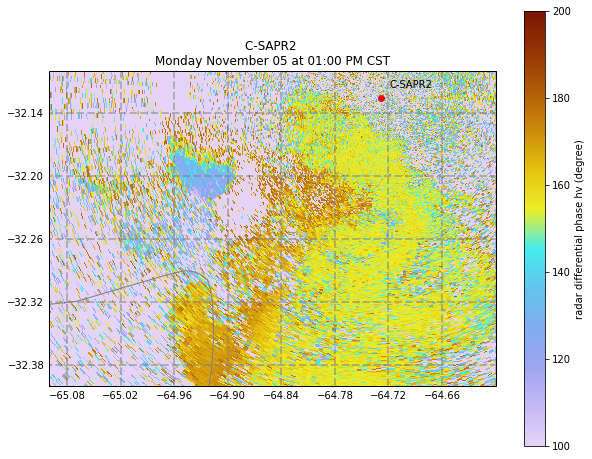

In [31]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'differential_phase', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=100, vmax=200, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


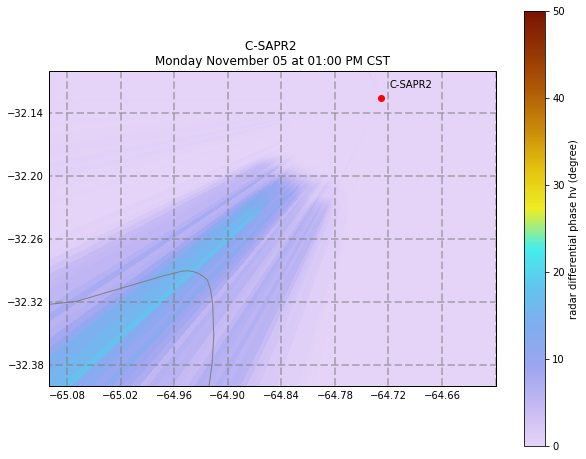

In [32]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'filtered_corrected_differential_phase', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=50, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


In [33]:
# Calculating attenuation by using pyart.
refl_field = field_config['reflectivity']
attenuation_a_coef = cmac_config['attenuation_a_coef']
c_coef = cmac_config['c_coef']
d_coef = cmac_config['d_coef']
beta_coef = cmac_config['beta_coef']
zdr_field = field_config['differential_reflectivity']

In [34]:
radar.fields['corrected_differential_reflectivity'] = copy.deepcopy(
    radar.fields[zdr_field])
radar.fields['corrected_reflectivity'] = copy.deepcopy(
    radar.fields[refl_field])
radar.fields['corrected_reflectivity']['data'] = np.ma.masked_where(
    cmac_gates.gate_excluded,
    radar.fields['corrected_reflectivity']['data'])

# Get specific differential attenuation.
# Need height over 0C isobar.
iso0 = np.ma.mean(radar.fields['height']['data'][
    np.where(np.abs(radar.fields['sounding_temperature']['data']) < 0.1)])
radar.fields['height_over_iso0'] = copy.deepcopy(radar.fields['height'])
radar.fields['height_over_iso0']['data'] -= iso0

In [35]:
(spec_at, pia_dict, cor_z, spec_diff_at,
 pida_dict, cor_zdr) = pyart.correct.calculate_attenuation_zphi(
     radar, temp_field='sounding_temperature',
     iso0_field='height_over_iso0',
     zdr_field='corrected_differential_reflectivity',
     pia_field='path_integrated_attenuation',
     refl_field='corrected_reflectivity', c=c_coef, d=d_coef,
     a_coef=attenuation_a_coef, beta=beta_coef)
cor_zdr['data'] += cmac_config['zdr_offset']
radar.add_field('specific_attenuation', spec_at, replace_existing=True)
radar.add_field('path_integrated_attenuation', pia_dict,
                replace_existing=True)
radar.add_field('corrected_reflectivity', cor_z, replace_existing=True)
radar.add_field('specific_differential_attenuation', spec_diff_at,
                replace_existing=True)
radar.add_field('path_integrated_differential_attenuation', pida_dict,
                replace_existing=True)
radar.add_field('corrected_differential_reflectivity', cor_zdr,
                replace_existing=True)


In [36]:
# https://journals.ametsoc.org/doi/pdf/10.1175/JAMC-D-13-0321.1

In [37]:
# Calculating rain rate.
R = 294.* (radar.fields['specific_attenuation']['data']) ** 0.89
rainrate = copy.deepcopy(radar.fields['specific_attenuation'])
rainrate['data'] = R
rainrate['valid_min'] = 0.0
rainrate['valid_max'] = 400.0
rainrate['standard_name'] = 'rainfall_rate'
rainrate['long_name'] = 'rainfall_rate'
rainrate['least_significant_digit'] = 1
rainrate['units'] = 'mm/hr'
radar.fields.update({'rain_rate_A': rainrate})

# This needs to be updated to a gatefilter.
mask = radar.fields['reflectivity']['data'].mask

radar.fields['rain_rate_A']['data'][np.where(mask)] = 0.0
radar.fields['rain_rate_A'].update({
    'comment': ('Rain rate calculated from specific_attenuation,',
                ' R=51.3*specific_attenuation**0.81, note R=0.0 where',
                ' norm coherent power < 0.4 or rhohv < 0.8')})

if verbose:
    print('## Rainfall rate as a function of A ##')

print('##')
print('## All CMAC fields have been added to the radar object.')
print('##')

## Rainfall rate as a function of A ##
##
## All CMAC fields have been added to the radar object.
##


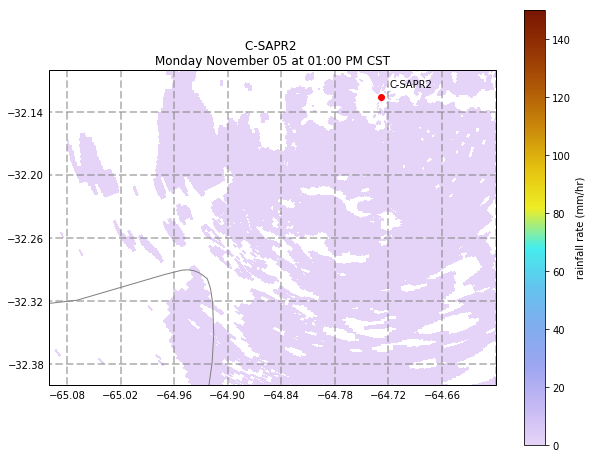

In [39]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'rain_rate_A', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=150, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
